## Izmir green space analysis with OSM data Step-3
In this step, spatial joins will be performed between the green spaces GeoPackaage dataset and the neighbourhood (Mahalle) and borough (ilçe)  shapefiles seperately.
The goal is to analyze the number of green areas at both the neighbourhood and borough levels by combining the spatial datasets.

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt

In [2]:
gdf_neigh = gpd.read_file("izmir_neighbourhood.shp") # Cleaned Izmir neighbourhood shapfile

In [3]:
gdf_bor = gpd.read_file("izmir_borough.shp") # Cleaned Izmir Borough shapefile

In [4]:
gdf_green = gpd.read_file("Izmır_green_data.gpkg") # Cleaned Izmir OSM green spaces dataset

### Note
The three required datasets are uploded. Before starting the analysis, the CRS (Coordinate Referance System) of each datasets will be checked.

In [5]:
print(gdf_neigh.crs)
print(gdf_bor.crs)
print(gdf_green.crs)

EPSG:4326
EPSG:4326
EPSG:4326


All datasets have the same __CRS__.

## Neighbourhood-level Spatial Join---sjoin
The shapefile dataset of neighbourhood and GeoPackage dataset will be spatially joined. Firstly we will analyze neighbourhood-level green areas numbers.

In [6]:
green_neigh = gpd.sjoin(gdf_green, gdf_neigh, how="inner", predicate="intersects")

In [7]:
green_neigh.head(2)

,element_type,osmid,leisure,landuse,natural,name,geometry,index_right,OBJECTID,ID,AD,ILCEID,TIP,SHAPE_Leng,SHAPE_Area,ILCE_ADI
0,node,3762437414,playground,None,None,None,POINT (27.37389 37.94258),615,2467,35483,Cumhuriyet,1612,Mahalle,0.08195,0.000358,SELCUK
24,way,452940050,park,None,None,None,POINT (27.37624 37.94335),615,2467,35483,Cumhuriyet,1612,Mahalle,0.08195,0.000358,SELCUK


### Green Per Neighbourhood
To analyze the number of green spaces per neighbourhood, the total count of green areas within each neighbourhood will be calculated and reset on a new column. This new column will be added to the existing neighbourhood dataset.


In [8]:
neigh_counts = green_neigh.groupby("AD").size().reset_index(name="green_per_neigh")

In [9]:
gdf_neigh = gdf_neigh.merge(neigh_counts,on="AD", how="left")
gdf_neigh["green_per_neigh"] = gdf_neigh["green_per_neigh"].fillna(0) # Neigh without green spaces will valued as 0.

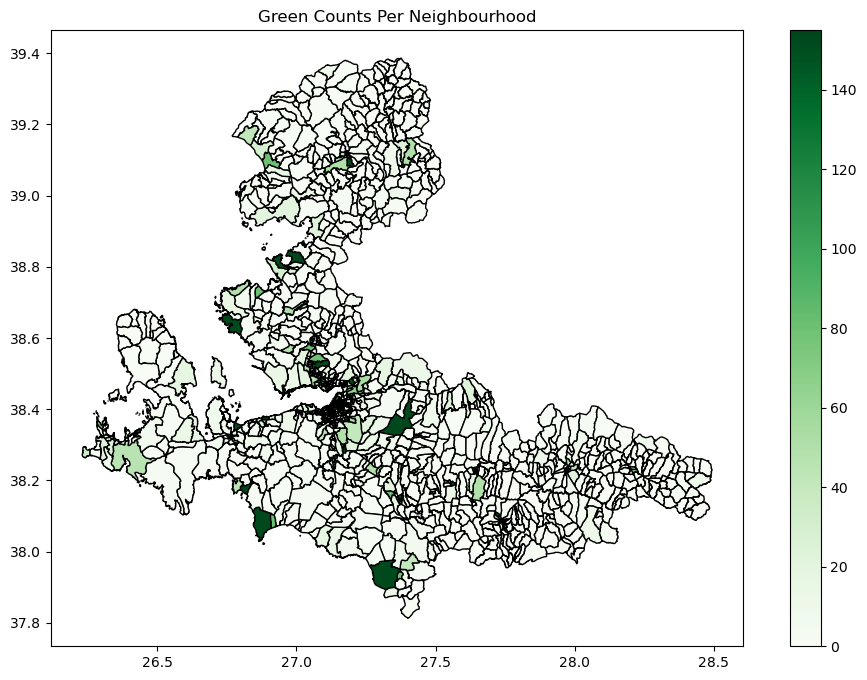

In [10]:
gdf_neigh.plot(
    column= "green_per_neigh",
    cmap= "Greens",
    legend = True,
    edgecolor = "black",
    figsize=(12,8)
)
plt.title("Green Counts Per Neighbourhood")
plt.show()

### İnceleme
The scale that goes 20 - 20 is not easly readable on the map. Therefore, new appropriate scale will be used.


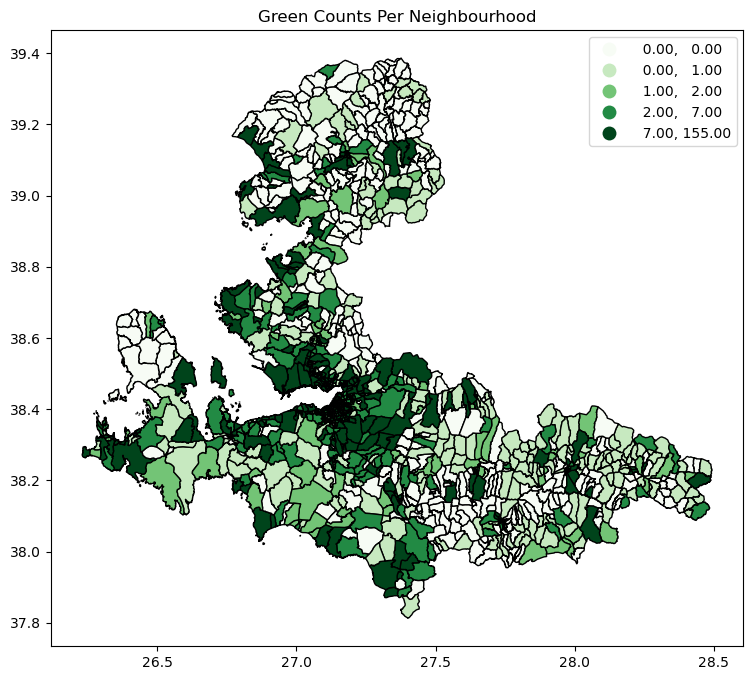

In [11]:
gdf_neigh.plot(
    column = "green_per_neigh",
    cmap = "Greens", 
    legend=True,
    edgecolor="black",
    figsize = (12,8),
    scheme = "quantiles",
    k=5
)
plt.title("Green Counts Per Neighbourhood")
plt.show()

In [12]:
gdf_neigh['green_per_neigh'].describe()

count    1336.000000
mean        8.075599
std        22.779572
min         0.000000
25%         0.000000
50%         1.000000
75%         5.000000
max       155.000000
Name: green_per_neigh, dtype: float64

### Evaluation
When examining the number of green areas per neighbourhood, it is observed that some neighbourhoods contain 155 green areas. This seems unrealistic and it might be related to the data structure and labeling.
At this point, these details will be ignored to maintain the project workflow, and will continue on borough-level analysis. Because, the main goal of the project is not to verify the data accuracy, but present a sample project workflow for green areas analysis.

In the later stages, the reasons behid theese outliers will be throughly examined and might be corrected.

## Borough-level Spatial Join---sjoin
At this point, the workflow continues with the analysis of green areas at the borough level.

In [13]:
green_per_bor = gpd.sjoin(gdf_green, gdf_bor, how="inner", predicate="intersects")

In [14]:
green_per_bor.head(2)

,element_type,osmid,leisure,landuse,natural,name,geometry,index_right,ILCE_ADI,OBJECTID,ID,AD,ILCEID,TIP,SHAPE_Leng,SHAPE_Area
0,node,3762437414,playground,None,None,None,POINT (27.37389 37.94258),25,SELCUK,1846,35487,Sultaniye,1612,K?rsal Mahalle,0.142578,0.001093
1,node,3999523005,playground,None,None,None,POINT (27.27746 37.93217),25,SELCUK,1846,35487,Sultaniye,1612,K?rsal Mahalle,0.142578,0.001093


### Green Per Borough
To analyze the number of green spaces per borough, the total count of green areas within each borough will be calculated.
This new column will then be added to the existing borogh shapefile dataset.

In [15]:
bor_counts = green_per_bor.groupby("ILCE_ADI").size().reset_index(name="green_per_bor")

In [16]:
gdf_bor = gdf_bor.merge(bor_counts, on="ILCE_ADI", how="left")
gdf_bor["green_per_bor"] = gdf_bor["green_per_bor"].fillna(0) # Yeşil alan olmayan İlçeler 0 olacak

In [17]:
gdf_bor.head(2)

,ILCE_ADI,OBJECTID,ID,AD,ILCEID,TIP,SHAPE_Leng,SHAPE_Area,geometry,green_per_bor
0,ALIAGA,2043,34284,A?a???akran,1128,K?rsal Mahalle,0.131118,0.000878,"MULTIPOLYGON (((27.02683 38.69684, 27.02668 38...",134
1,BALCOVA,2684,34326,Korutürk,2006,Mahalle,0.067043,0.000128,"POLYGON ((27.07063 38.38425, 27.07172 38.38293...",89


In [18]:
gdf_bor['green_per_bor'].describe()

count     29.000000
mean     146.275862
std      114.654106
min       23.000000
25%       73.000000
50%      109.000000
75%      172.000000
max      454.000000
Name: green_per_bor, dtype: float64

### Evaluation
At the borough level, the number of green areas ranges from 23 to 454, with an average of approximately 146 green areas per borough. As the neighbourhood level analysis, it is seems that the maximum value is quite high. 
This unrealistic output will be ignored for this stage and will be examined in the further projects.

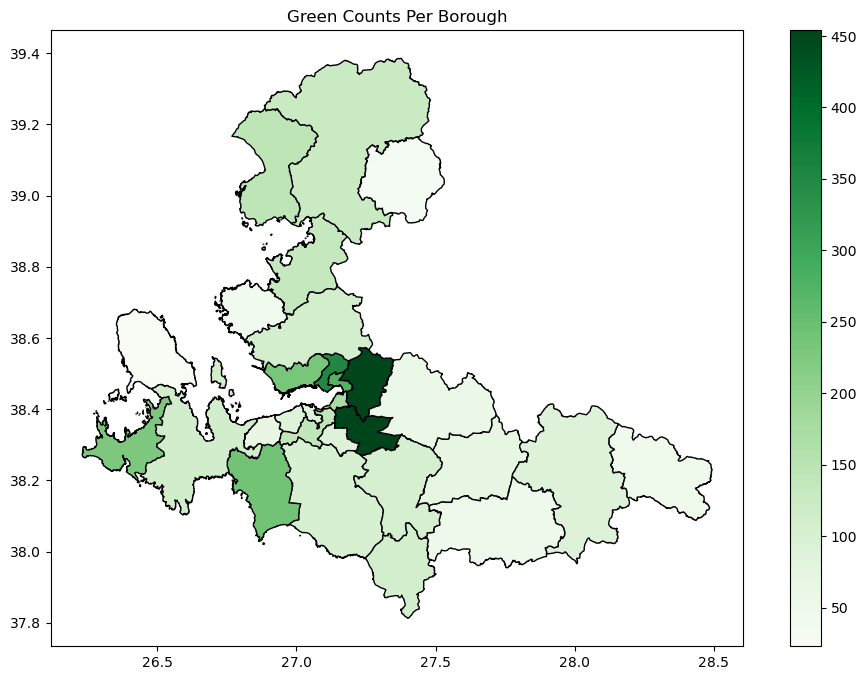

In [19]:
gdf_bor.plot(
    column = "green_per_bor",
    cmap = "Greens", 
    legend=True,
    edgecolor="black",
    figsize = (12,8),
)
plt.title("Green Counts Per Borough")
plt.show()

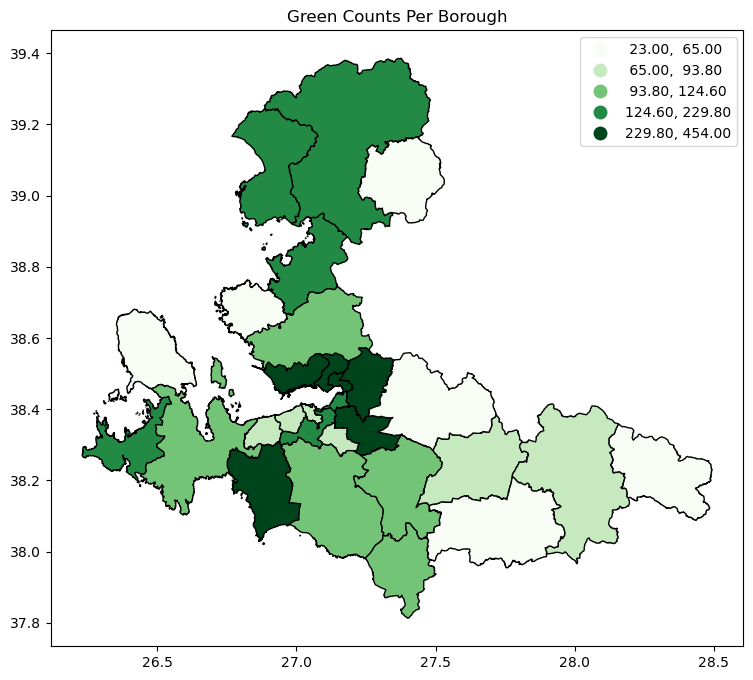

In [20]:
gdf_bor.plot(
    column = "green_per_bor",
    cmap = "Greens", 
    legend=True,
    edgecolor="black",
    figsize = (12,8),
    scheme = "quantiles",
    k=5
)
plt.title("Green Counts Per Borough")
plt.show()

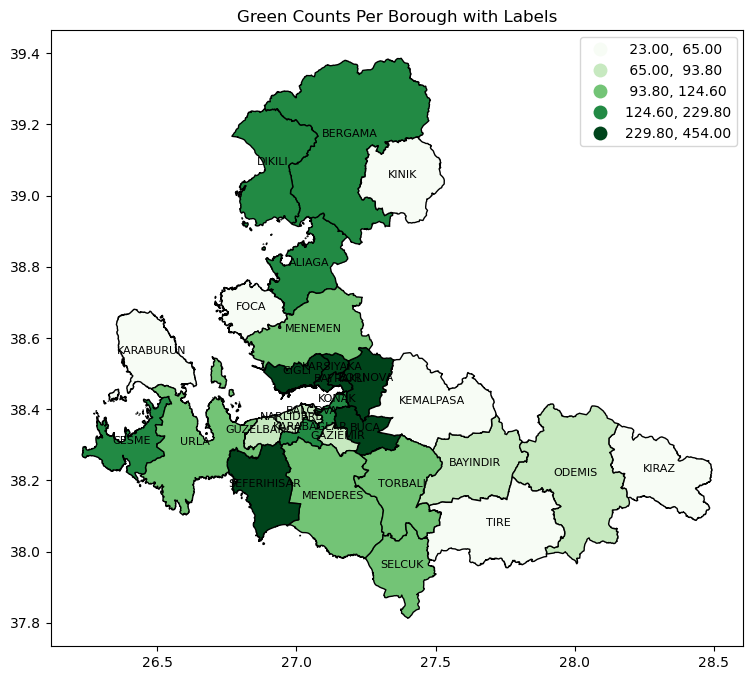

In [21]:
ax = gdf_bor.plot(
    column="green_per_bor",
    cmap="Greens",
    legend=True,
    edgecolor="black",
    figsize=(12,8),
    scheme="quantiles",
    k=5
)

# İlçe isimlerini ekleme
for idx, row in gdf_bor.iterrows():
    # Poligonun centroid'ini alıyoruz
    plt.annotate(
        text=row['ILCE_ADI'],           # İlçe adı sütunu
        xy=(row.geometry.centroid.x, row.geometry.centroid.y),
        horizontalalignment='center',
        fontsize=8,
        color='black'
    )

plt.title("Green Counts Per Borough with Labels")
plt.show()

## Project Summary
With the borough level analysis completed, the project is now conclude. The project has been done in three steps;

__Step 1:__ OSM green space data for Izmir was obtained, and necessary cleaning and adjustments were applied to create usefull dataset.

__Step 2:__ The neighbourhood-level shapefile dataset examined and adjusted, after that both neighbourhood and borough shapefiles for Izmir generated.

__Step 3:__ These datasets spatially joined at this stage and anlayzed.

As previously noted, the main pupose of this project was not to verify data accuracy or consistency, but to demonstrate an example analysis workflow with spatial data in different formats (__shp__, __gpkg__). Therefore, future studies will focus on improving data quality, performing deeper analyses on OSM datasets, and generating more meaningful spatial insights.
